In [1]:
import seaborn as sns; sns.set_theme(color_codes=True)
from dtwhaclustering.dtw_analysis import dtw_signal_pairs, dtw_clustering
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from dtaidistance import dtw
import pandas as pd
import os
from dtaidistance.clustering import HierarchicalTree
from scipy.cluster import hierarchy

%matplotlib inline 

# default matplotlib parameters
import matplotlib
font = {'family': 'Times',
        'weight': 'bold',
        'size': 22}

matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use('ggplot')

In [2]:
#load pickle data
dataloc = "pickleFiles"

final_dU=pd.read_pickle(os.path.join(dataloc,"dU_wo_seasn.pickle"))
final_dN=pd.read_pickle(os.path.join(dataloc,"dN_wo_seasn.pickle"))
final_dE=pd.read_pickle(os.path.join(dataloc,"dE_wo_seasn.pickle"))

In [3]:
final_dU.head()

,DAWU_U,GS36_U,CTOU_U,HSIN_U,GS31_U,SSUN_U,SFON_U,GS23_U,VR03_U,SLNP_U,...,DOSH_U,W029_U,NSHE_U,HUWE_U,SHJU_U,DNAN_U,PKGM_U,SLIN_U,MESN_U,WULU_U
Time,,,,,,,,,,,,,,,,,,,,,
2007-01-01,3.908294,-0.081488,-3.049840,-4.673059,10.533776,-1.476313,8.673984,4.530060,13.409948,-8.877830,...,-19.377178,-3.788125,1.743015,130.023461,8.220618,66.794490,-30.720817,-3.034473,-3.599844,-57.474679
2007-01-02,10.500799,7.948431,1.318779,-0.743764,9.331000,3.753709,6.669562,4.629491,22.623746,3.637930,...,-8.896452,-6.097189,8.503721,137.846113,13.530092,70.849086,-24.866085,-12.179227,-14.733458,-47.341336
2007-01-03,4.008854,6.446352,4.105762,12.184217,9.198563,7.073537,6.987663,13.166624,12.013241,-4.880878,...,-22.097870,9.628858,2.767164,138.107636,16.818000,72.697599,-19.829117,-21.627860,-11.893865,-51.522350
2007-01-04,-0.031345,-0.846752,0.427601,-3.944638,6.705640,-2.433624,6.980915,5.301272,14.671148,-12.261464,...,-18.980924,-11.738634,-0.707047,129.183137,2.833268,66.621516,-31.362671,-29.660110,-19.988452,-59.711777
2007-01-05,-3.235729,2.166184,-3.995197,-6.788471,6.111140,-2.830265,-0.087687,3.937724,14.986668,-6.464705,...,-17.883469,-8.798023,-1.576212,128.433947,-2.769286,68.346757,-28.545909,-29.302730,-39.140370,-84.028366


In [54]:
labels = [stnU.split("_")[0] for stnU in final_dU.columns.values] #remove the prefix _U

In [4]:
time_series_U = final_dU.values.transpose()

In [5]:
# ds = dtw.distance_matrix_fast(
#             time_series_U, compact=False, block=None)
# ds

In [7]:
# labels = [stnU.split("_")[0] for stnU in final_dU.columns.values]
# dfU = pd.DataFrame(data=ds,index=labels, columns=labels)


In [10]:
model = HierarchicalTree(
            dists_fun=dtw.distance_matrix_fast, dists_options={}, show_progress=True)
cluster_idx = model.fit(time_series_U)

The compiled dtaidistance C-OMP library is not available.
Use Python's multiprocessing library for parellelization (use_mp=True).
See the documentation for alternative installation options.
The compiled dtaidistance C-OMP library is not available.
Using the Python multiprocessing library instead (use_mp=True).
See the documentation for alternative installation options.

 99%|█████████▉| 114/115 [00:00<00:00, 9708.05it/s]


In [11]:
linkage_matrix = model.linkage

In [12]:
R = hierarchy.dendrogram(
            linkage_matrix, no_plot=True)

In [134]:
icoord = np.asarray(R["icoord"], dtype=float)
dcoord = np.asarray(R["dcoord"], dtype=float)
len(icoord), len(dcoord)

(114, 114)

In [135]:
def smoothsegment(seg, Nsmooth=50):
    return np.concatenate([[seg[0]], np.linspace(seg[1], seg[2], Nsmooth), [seg[3]]])

In [214]:
def plot_dendrogram(icoord,dcoord,figsize=(20,20),normfactor=None, polar=True,labels=None,Nyticks=7, gap = 0.1, Nsmooth=1,plotstyle="seaborn"):
    if normfactor is None:
        normfactor = (dcoord.max()-dcoord.min())/len(dcoord)
    if polar:
        dcoordlog = -np.log(dcoord+normfactor)
        # avoid a wedge over the radial labels
        
        imax = icoord.max()
        imin = icoord.min()
        icoord = ((icoord - imin)/(imax - imin)*(1-gap) + gap/2)*2*np.pi
    with plt.style.context(plotstyle):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, polar=polar)
        for xs, ys in zip(icoord, dcoordlog):
            if polar:
                xs = smoothsegment(xs,Nsmooth=Nsmooth)
                ys = smoothsegment(ys,Nsmooth=Nsmooth)
            ax.plot(xs,ys, color="black")
        if polar:
            ax.spines['polar'].set_visible(False)
            ax.set_rlabel_position(0)
            Nxticks = len(icoord)+1
            xticks = np.linspace(gap/2, 1-gap/2, Nxticks)
            ax.set_xticks(xticks*np.pi*2)
            if labels is None:
                ax.set_xticklabels(np.round(np.linspace(imin, imax, Nxticks)).astype(int), rotation = 90, fontsize=20)
            else:
                ax.set_xticklabels(labels, rotation = 90, fontsize=20)
            ytickslog = np.linspace(dcoordlog.min(),dcoordlog.max(), Nyticks)

            ax.set_yticks(ytickslog[:-1])
            ytickslabels = np.e**(-ytickslog[:-1])-50
            ytickslabels = [f"{ylab:.1f}" for ylab in ytickslabels]
            ax.set_yticklabels(ytickslabels, fontsize=20, rotation = 90)


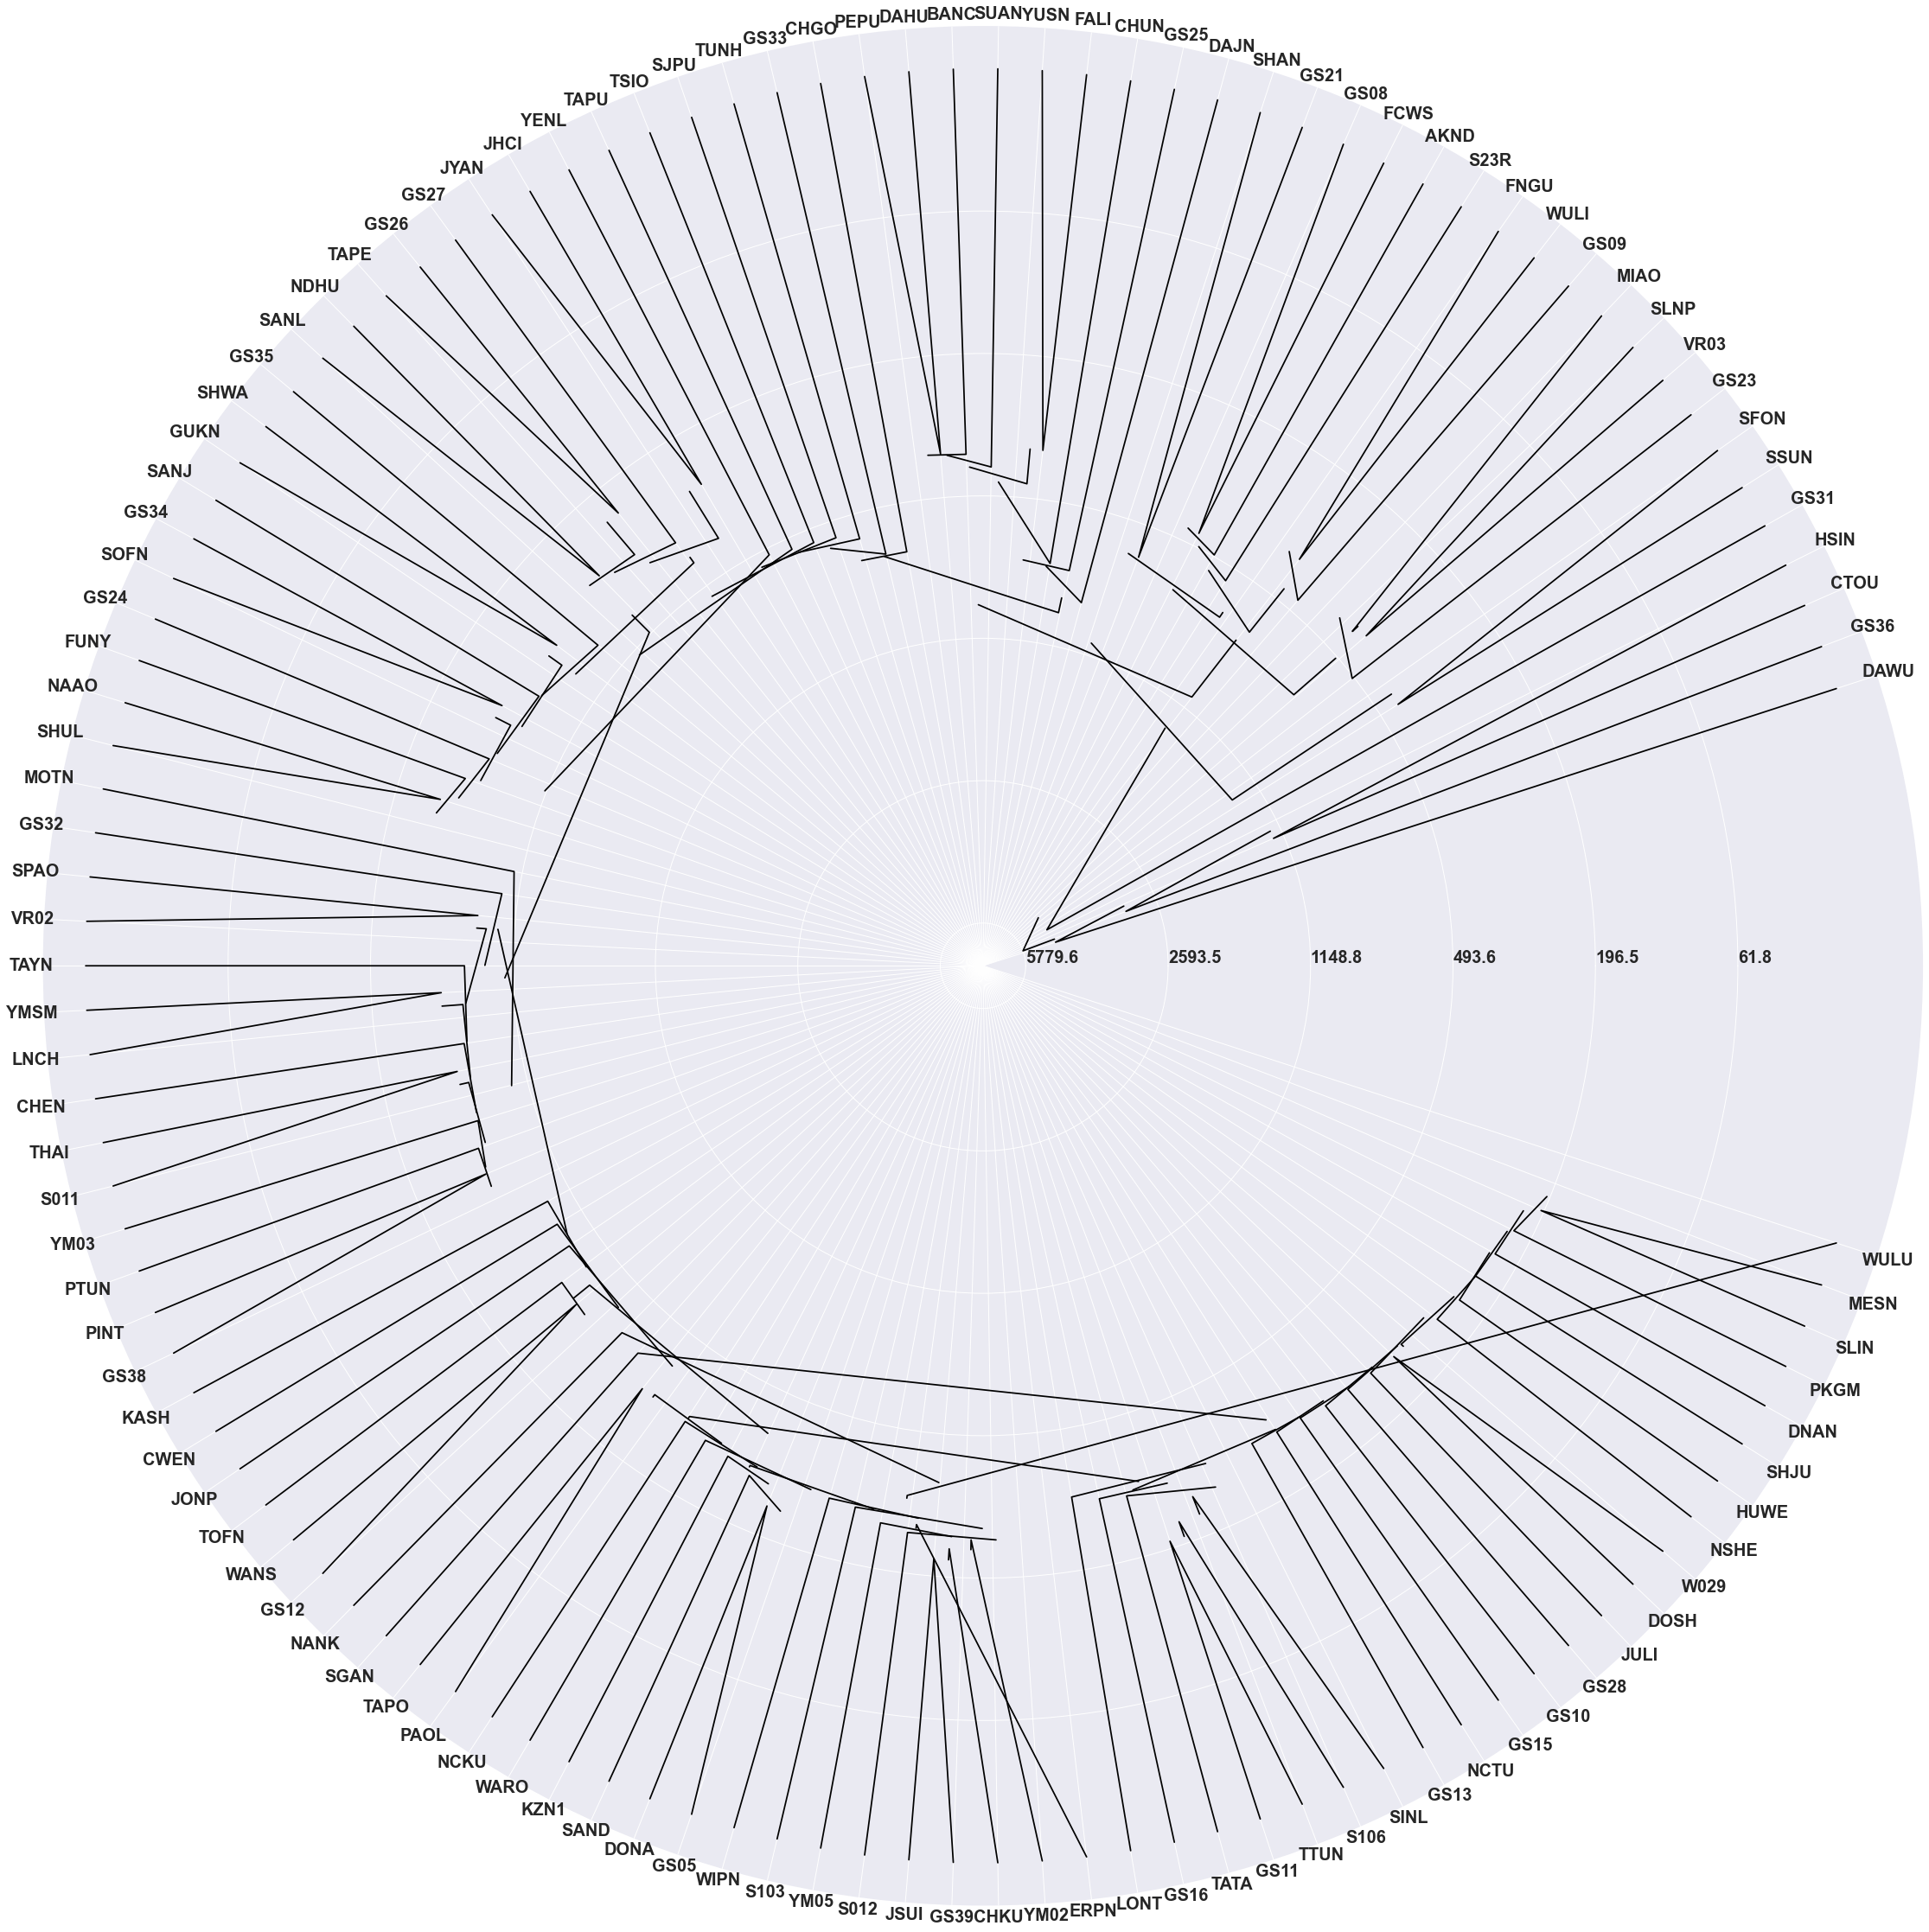

In [215]:
plot_dendrogram(icoord,dcoord,figsize=(40,40), polar=True, labels=labels)